In [1]:
import json
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy import stats
import torch
from torchvision import transforms
from PIL import Image

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Additional imports for model ensemble
import os
import string

import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

import zipfile
from io import BytesIO

In [2]:
def decode_base64_image(base64_string):
    img_data = base64.b64decode(base64_string.split(',')[1])
    return Image.open(BytesIO(img_data))

def create_composite_image(images):
    if not images:
        return np.zeros((28, 28, 3), dtype=np.uint8)
    
    np_images = [np.array(img.convert('RGB').resize((28, 28))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return (mean_image * 255).astype(np.uint8)

def compute_vviq_score(vviq_data):
    total_score = 0
    num_items = 0
    for condition in vviq_data.values():
        for item in condition:
            for key, value in item.items():
                if key.startswith('row'):
                    total_score += int(value)
                    num_items += 1
    return total_score / num_items if num_items > 0 else 0

def compute_caps_score(caps_data):
    total_score = 0
    for item in caps_data:
        if item['response'] == 'yes':
            for value in item.get('subscale', {}).values():
                total_score += int(value)
    return total_score

def process_participant_data(participant_data):
    # Extract demographic data
    demographics = participant_data['demographics']
    
    # Process VVIQ data
    vviq_score = compute_vviq_score(participant_data['vviq'])
    
    # Process CAPS data
    caps_score = compute_caps_score(participant_data['caps'])
    
    # Process training trials
    training_trials = [trial for trial in participant_data['trials'] if trial.get('trial_type') == 'training']
    correct_training_trials = sum(1 for trial in training_trials if trial.get('correct', False))
    training_accuracy = (correct_training_trials / len(training_trials)) * 100 if training_trials else 0
    
    # Process main experiment trials
    main_trials = [trial for trial in participant_data['trials'] if 'block_number' in trial]
    selected_images = {1: [], 2: []}
    non_selected_images = {1: [], 2: []}
    
    for trial in main_trials:
        block = trial['block_number']
        for stimulus in trial['stimuli']:
            img = decode_base64_image(stimulus['dataURL'])
            if stimulus['selected']:
                selected_images[block].append(img)
            else:
                non_selected_images[block].append(img)
    
    # Create composites
    composites = {
        'selected': {
            1: create_composite_image(selected_images[1]),
            2: create_composite_image(selected_images[2]),
            'all': create_composite_image(selected_images[1] + selected_images[2])
        },
        'non_selected': {
            1: create_composite_image(non_selected_images[1]),
            2: create_composite_image(non_selected_images[2]),
            'all': create_composite_image(non_selected_images[1] + non_selected_images[2])
        }
    }
    
    # Create enhanced composites
    enhanced_composites = {
        1: composites['selected'][1] - composites['non_selected'][1],
        2: composites['selected'][2] - composites['non_selected'][2],
        'all': composites['selected']['all'] - composites['non_selected']['all']
    }
    
    return {
        'participant_id': participant_data['participant_id'],
        'demographics': demographics,
        'vviq_score': vviq_score,
        'caps_score': caps_score,
        'training_accuracy': training_accuracy,
        'composites': composites,
        'enhanced_composites': enhanced_composites,
        'num_selections': {
            'block1': len(selected_images[1]),
            'block2': len(selected_images[2]),
            'total': len(selected_images[1]) + len(selected_images[2])
        }
    }

def load_and_process_jrzip(file_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        all_participants_data = {}
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as file:
                    participant_data = json.load(file)
                    processed_data = process_participant_data(participant_data)
                    all_participants_data[processed_data['participant_id']] = processed_data
    return all_participants_data

def display_results(all_participants_data):
    for participant_id, data in all_participants_data.items():
        print(f"\nParticipant ID: {participant_id}")
        print(f"Age: {data['demographics']['age']}, Gender: {data['demographics']['gender']}")
        print(f"VVIQ Score: {data['vviq_score']:.2f}")
        print(f"CAPS Score: {data['caps_score']}")
        print(f"Training Accuracy: {data['training_accuracy']:.2f}%")
        print(f"Number of selections - Block 1: {data['num_selections']['block1']}, Block 2: {data['num_selections']['block2']}, Total: {data['num_selections']['total']}")
        
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f"Participant {participant_id} Results", fontsize=16)
        
        axes[0, 0].imshow(data['composites']['selected'][1])
        axes[0, 0].set_title('Block 1 Selected Composite')
        axes[0, 1].imshow(data['composites']['selected'][2])
        axes[0, 1].set_title('Block 2 Selected Composite')
        axes[0, 2].imshow(data['composites']['selected']['all'])
        axes[0, 2].set_title('All Selected Composite')
        
        axes[1, 0].imshow(data['composites']['non_selected'][1])
        axes[1, 0].set_title('Block 1 Non-Selected Composite')
        axes[1, 1].imshow(data['composites']['non_selected'][2])
        axes[1, 1].set_title('Block 2 Non-Selected Composite')
        axes[1, 2].imshow(data['composites']['non_selected']['all'])
        axes[1, 2].set_title('All Non-Selected Composite')
        
        axes[2, 0].imshow(data['enhanced_composites'][1])
        axes[2, 0].set_title('Block 1 Enhanced Composite')
        axes[2, 1].imshow(data['enhanced_composites'][2])
        axes[2, 1].set_title('Block 2 Enhanced Composite')
        axes[2, 2].imshow(data['enhanced_composites']['all'])
        axes[2, 2].set_title('All Enhanced Composite')
        
        for ax in axes.flat:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()


Participant ID: d
Age: 18, Gender: Male
VVIQ Score: 2.47
CAPS Score: 0
Training Accuracy: 80.00%
Number of selections - Block 1: 50, Block 2: 50, Total: 100


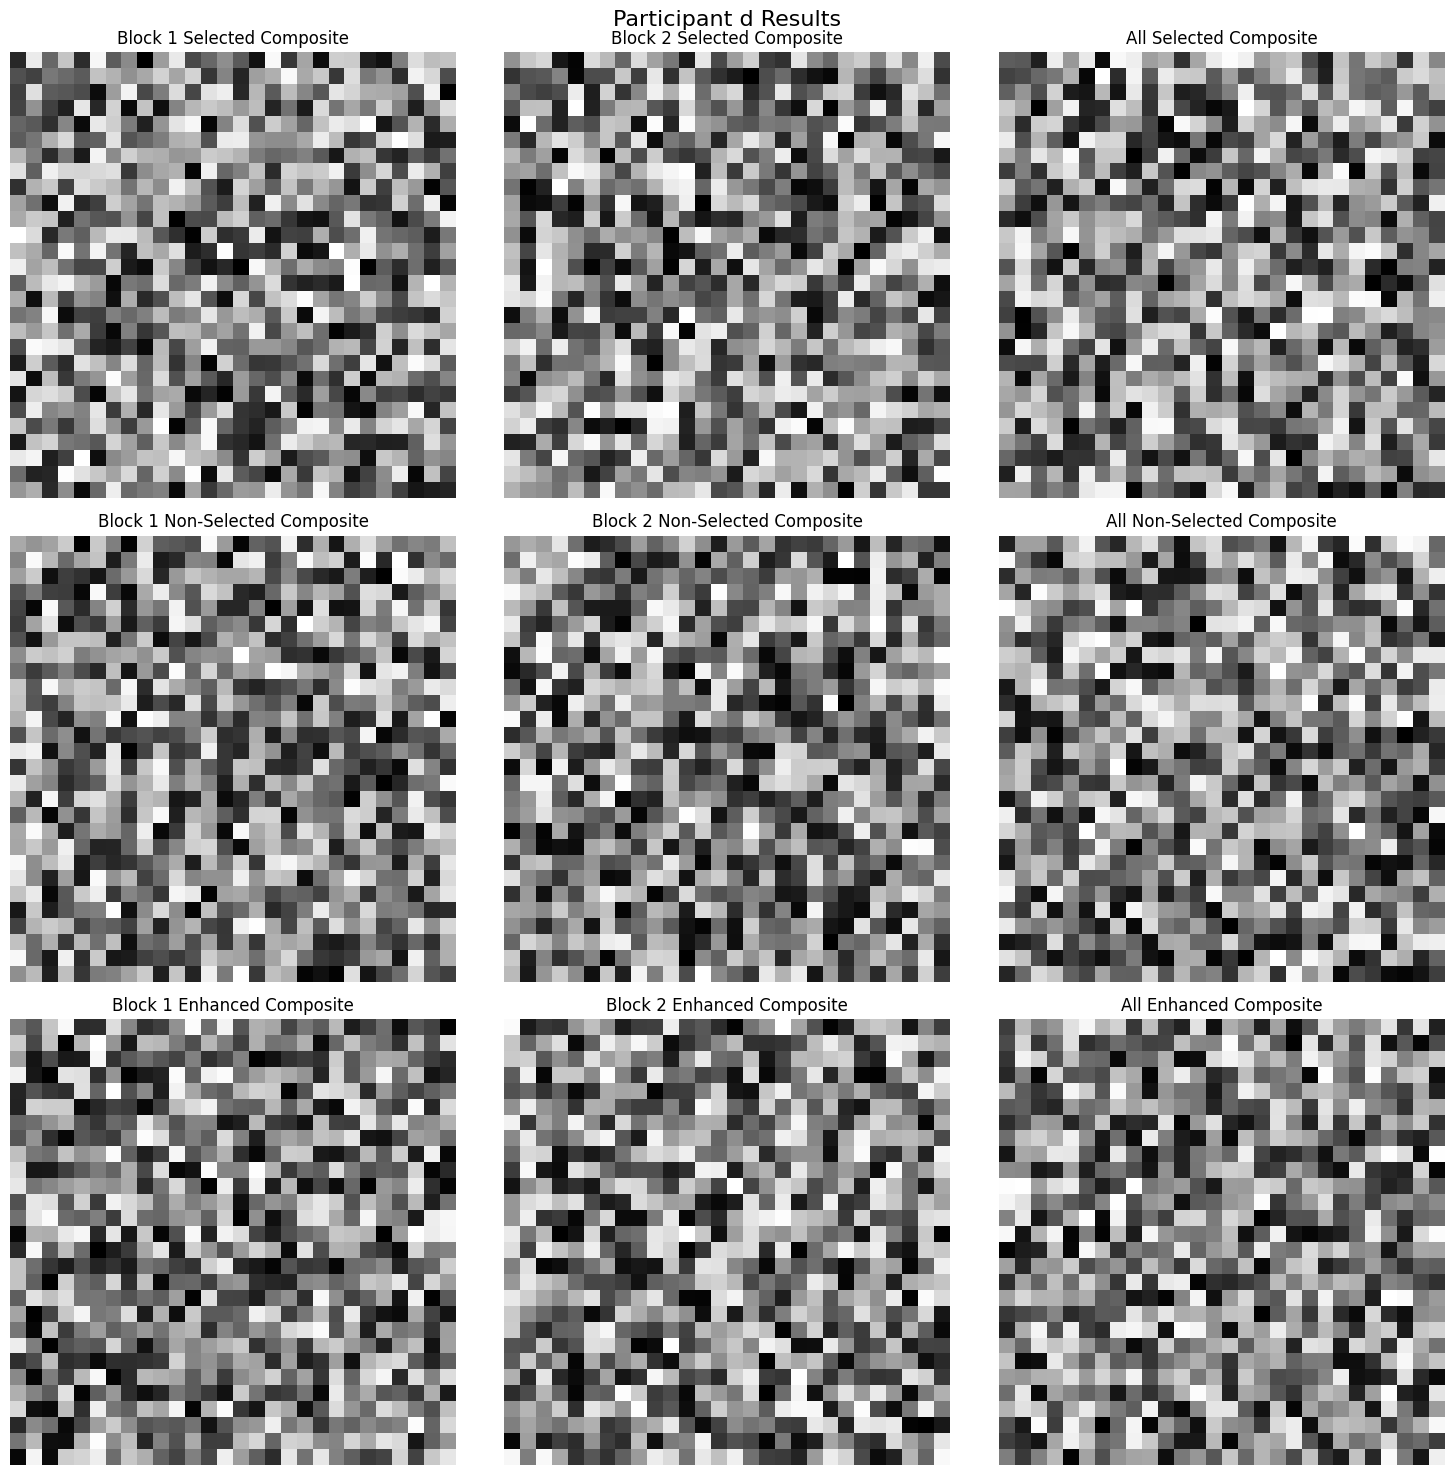


Participant ID: 88755
Age: 29, Gender: Male
VVIQ Score: 0.35
CAPS Score: 21
Training Accuracy: 0.00%
Number of selections - Block 1: 50, Block 2: 50, Total: 100


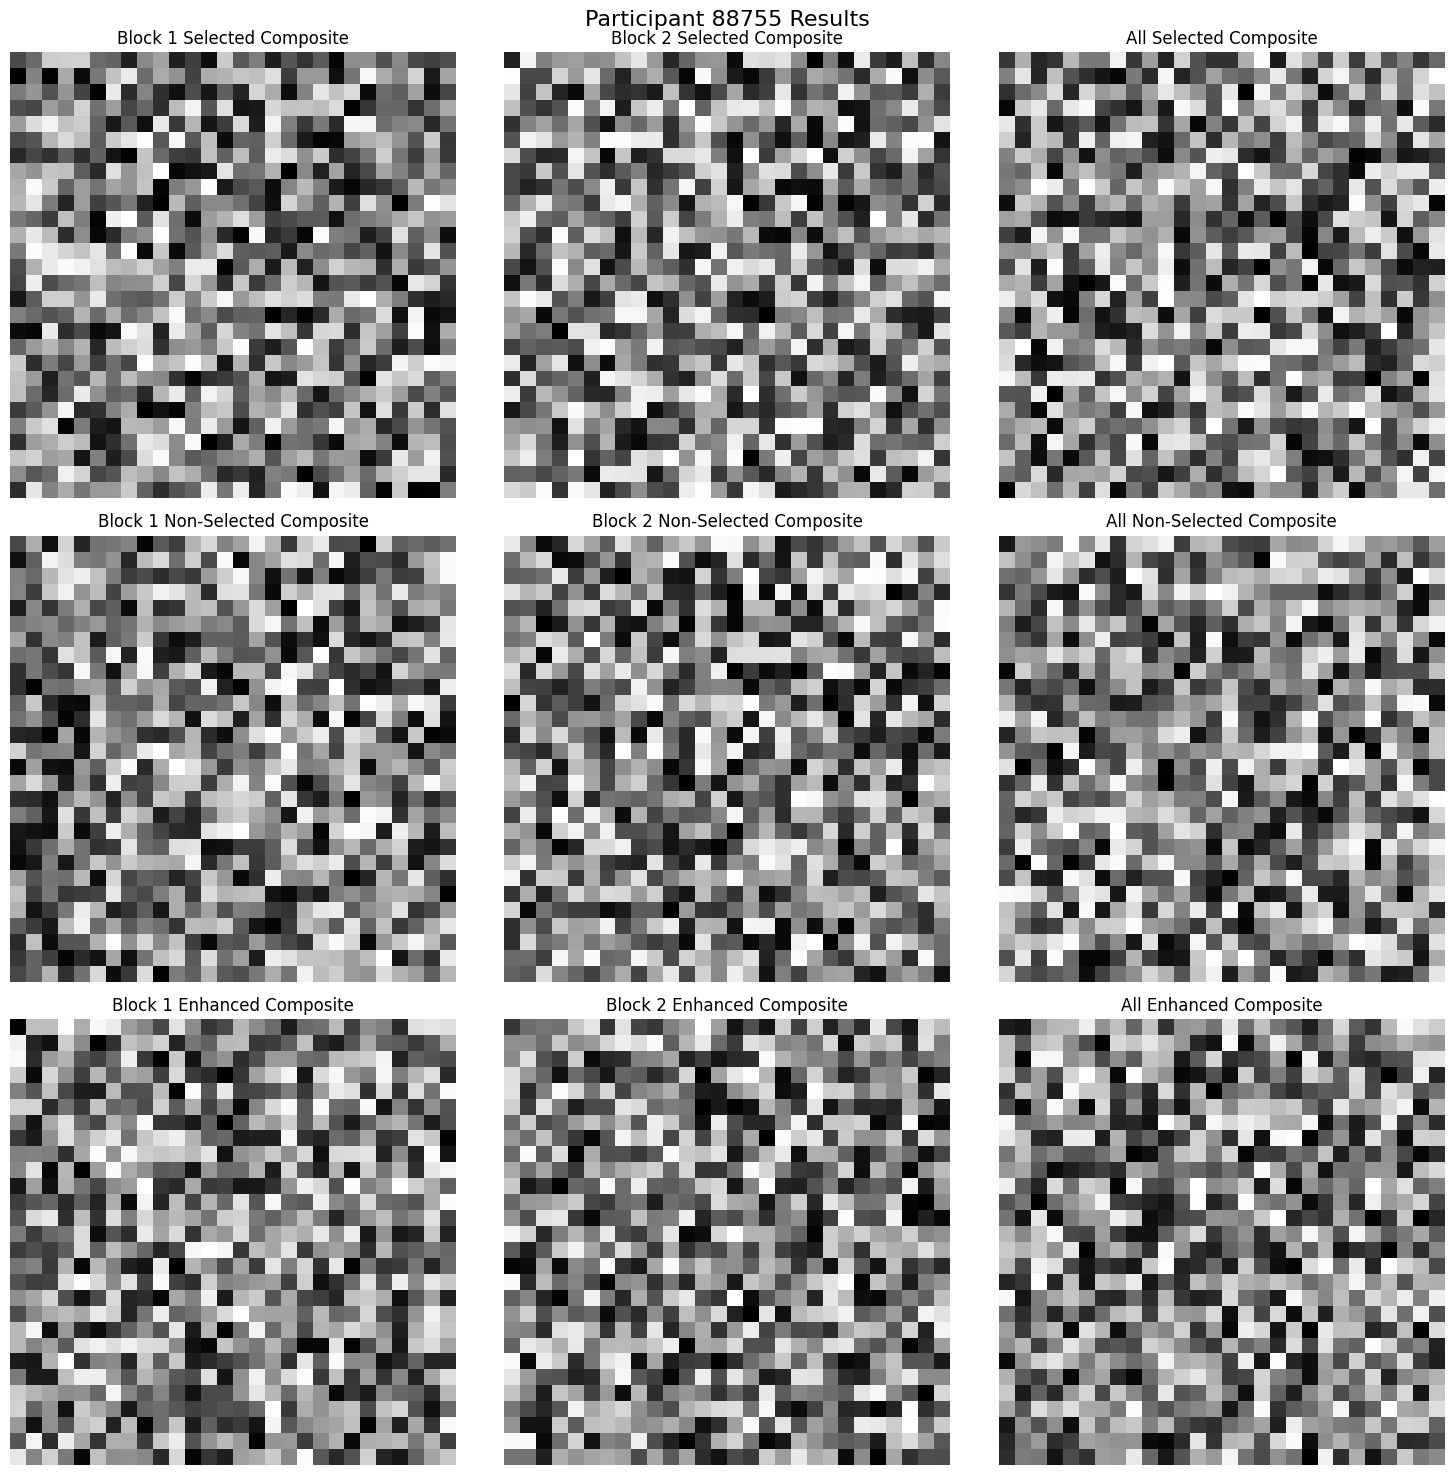


Participant ID: 275555
Age: 21, Gender: Male
VVIQ Score: 2.65
CAPS Score: 31
Training Accuracy: 90.00%
Number of selections - Block 1: 50, Block 2: 50, Total: 100


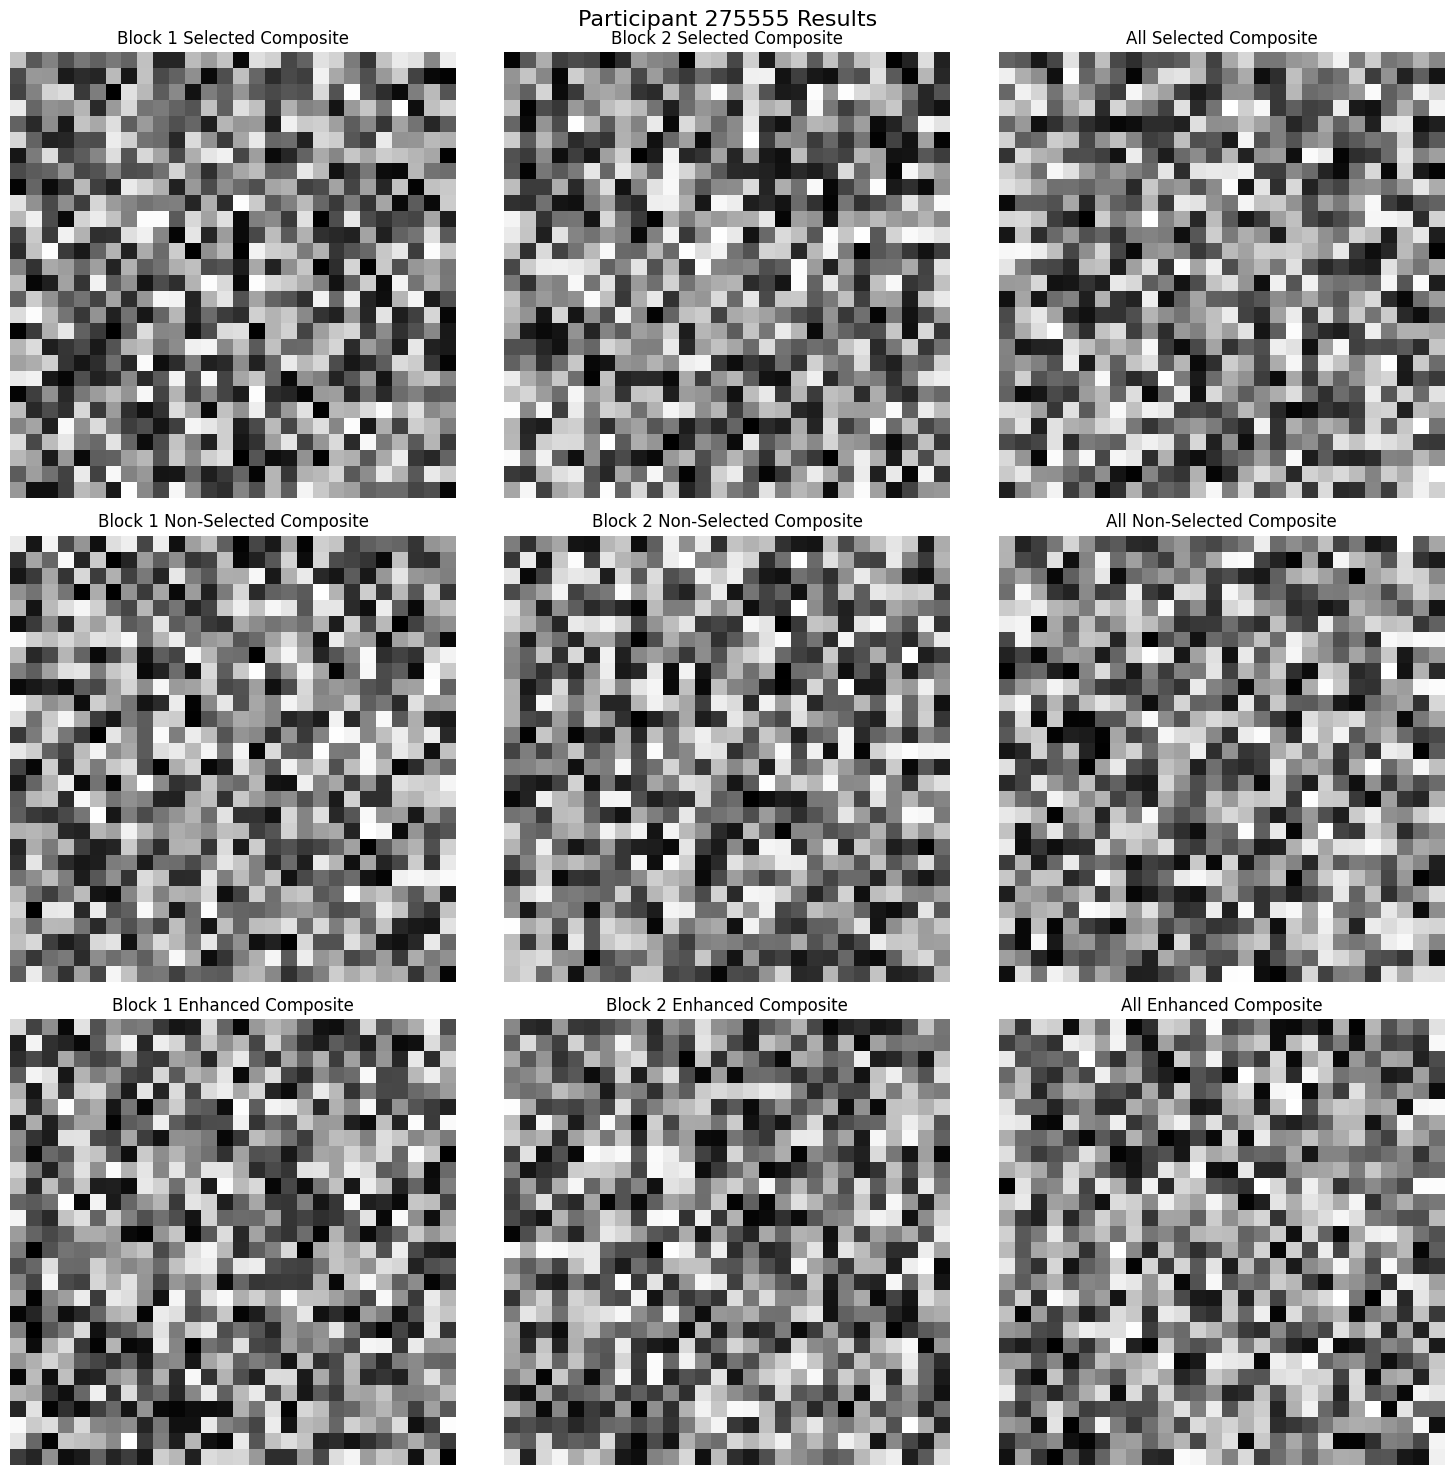


Participant ID: tyl2g22
Age: 21, Gender: Female
VVIQ Score: 1.74
CAPS Score: 88
Training Accuracy: 90.00%
Number of selections - Block 1: 50, Block 2: 50, Total: 100


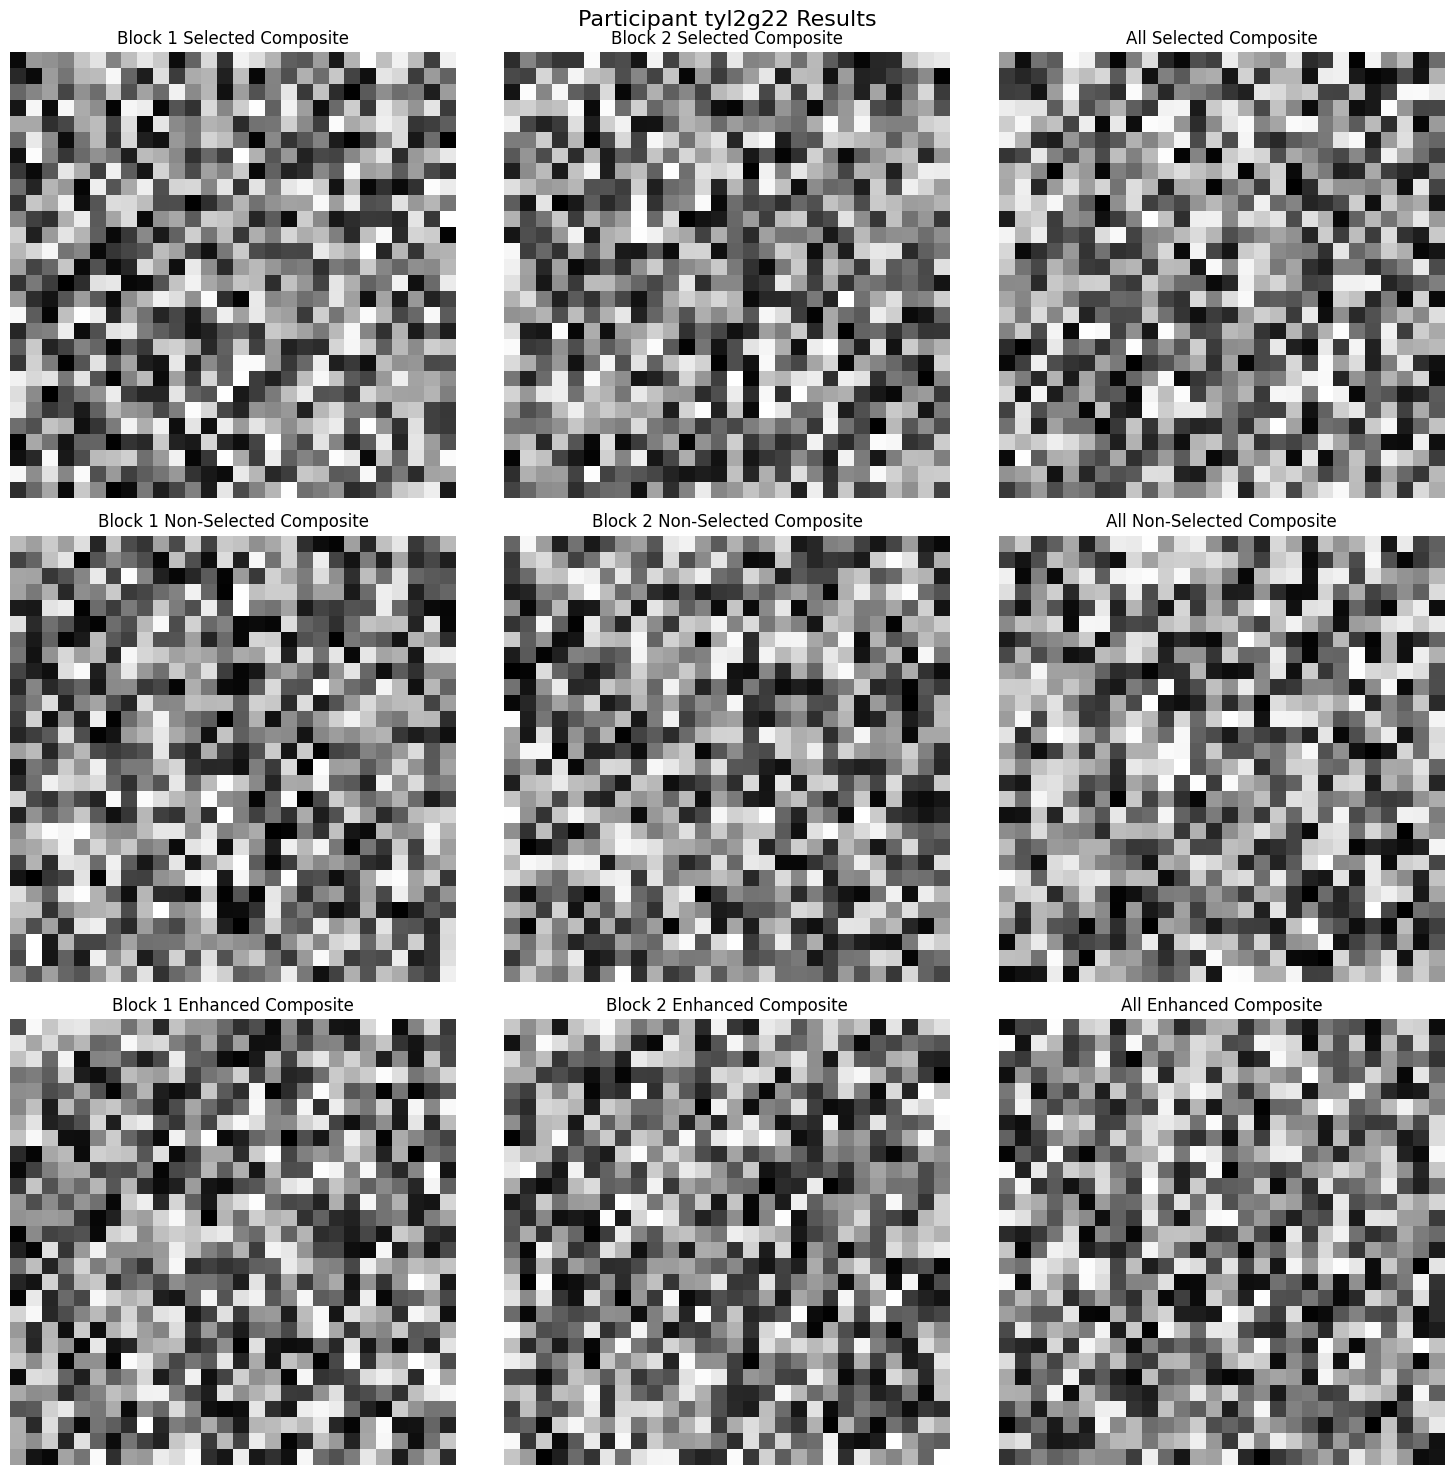


Participant ID: ab8n22
Age: 22, Gender: Non-binary/Third Gender
VVIQ Score: 0.56
CAPS Score: 115
Training Accuracy: 90.00%
Number of selections - Block 1: 50, Block 2: 50, Total: 100


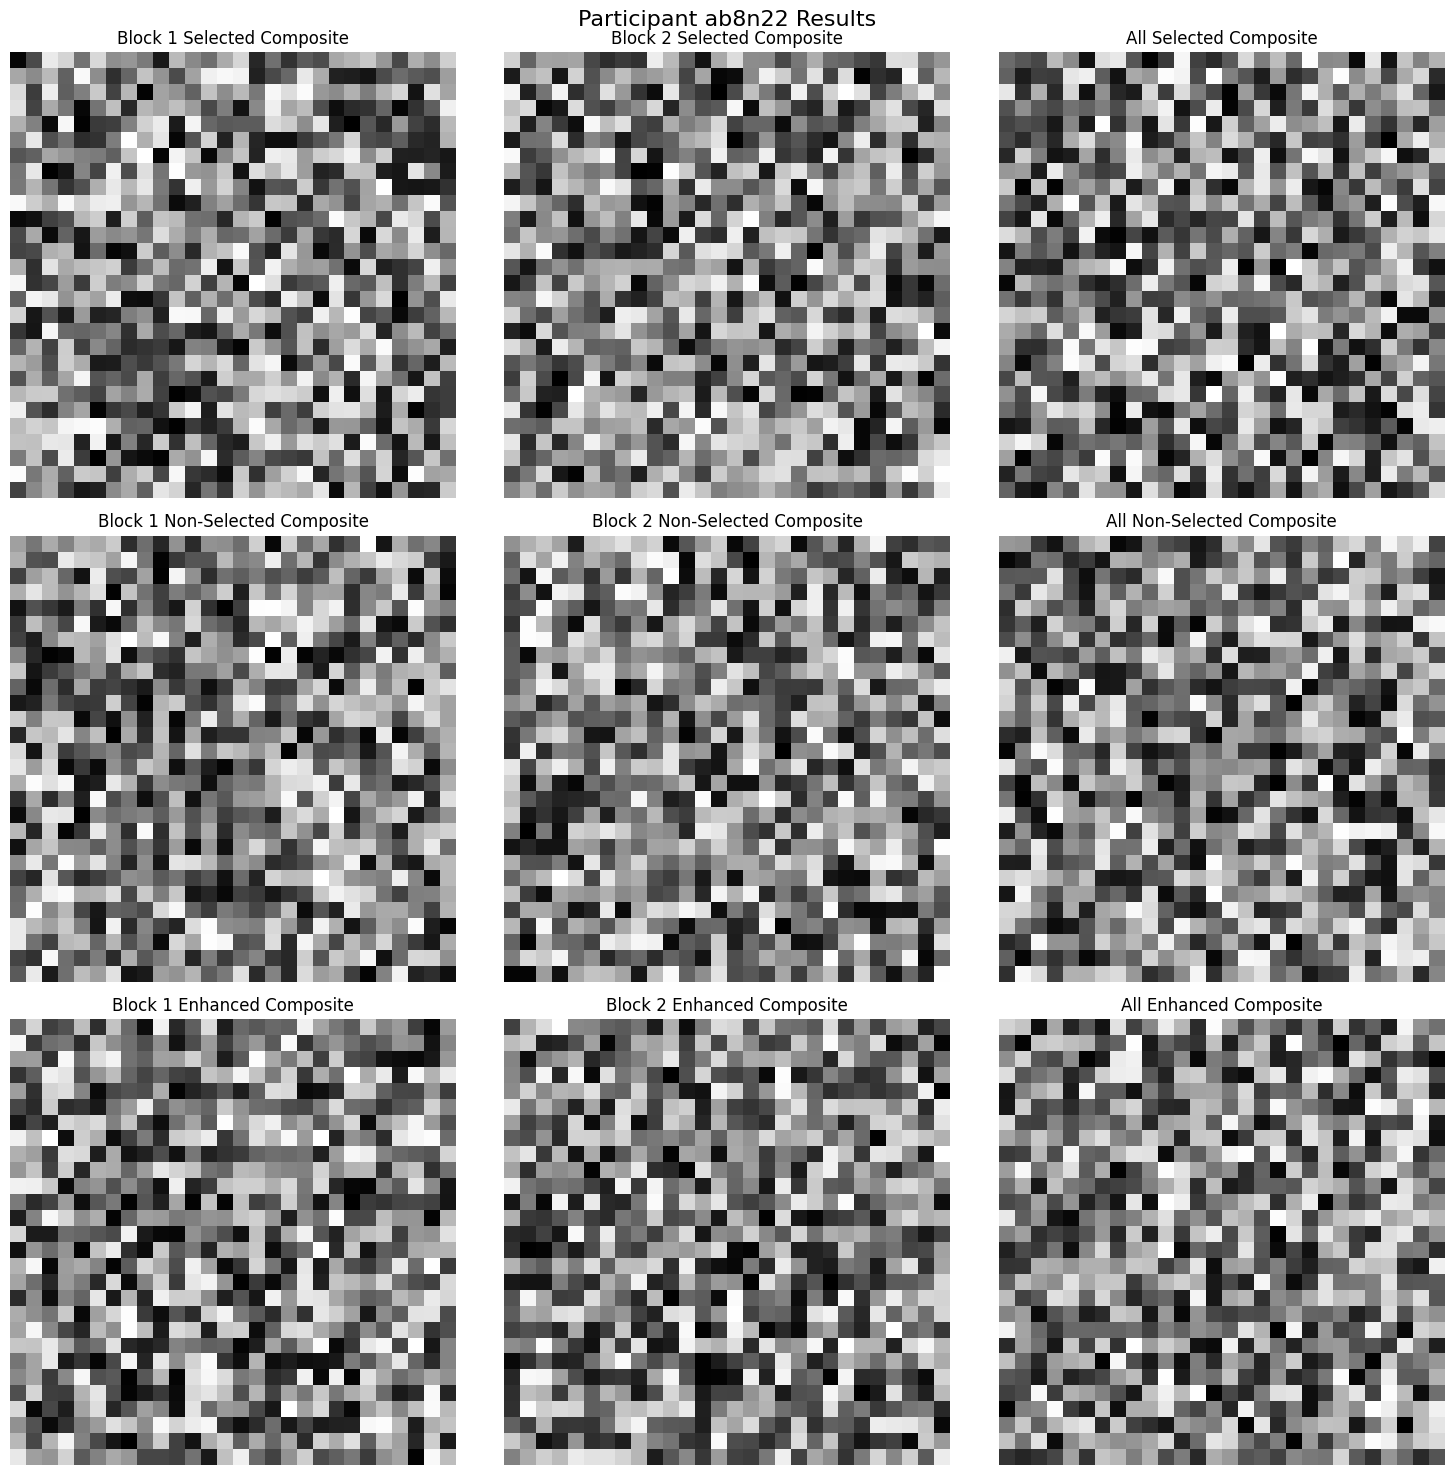


Participant ID: 110424
Age: 38, Gender: Female
VVIQ Score: 1.97
CAPS Score: 20
Training Accuracy: 100.00%
Number of selections - Block 1: 50, Block 2: 50, Total: 100


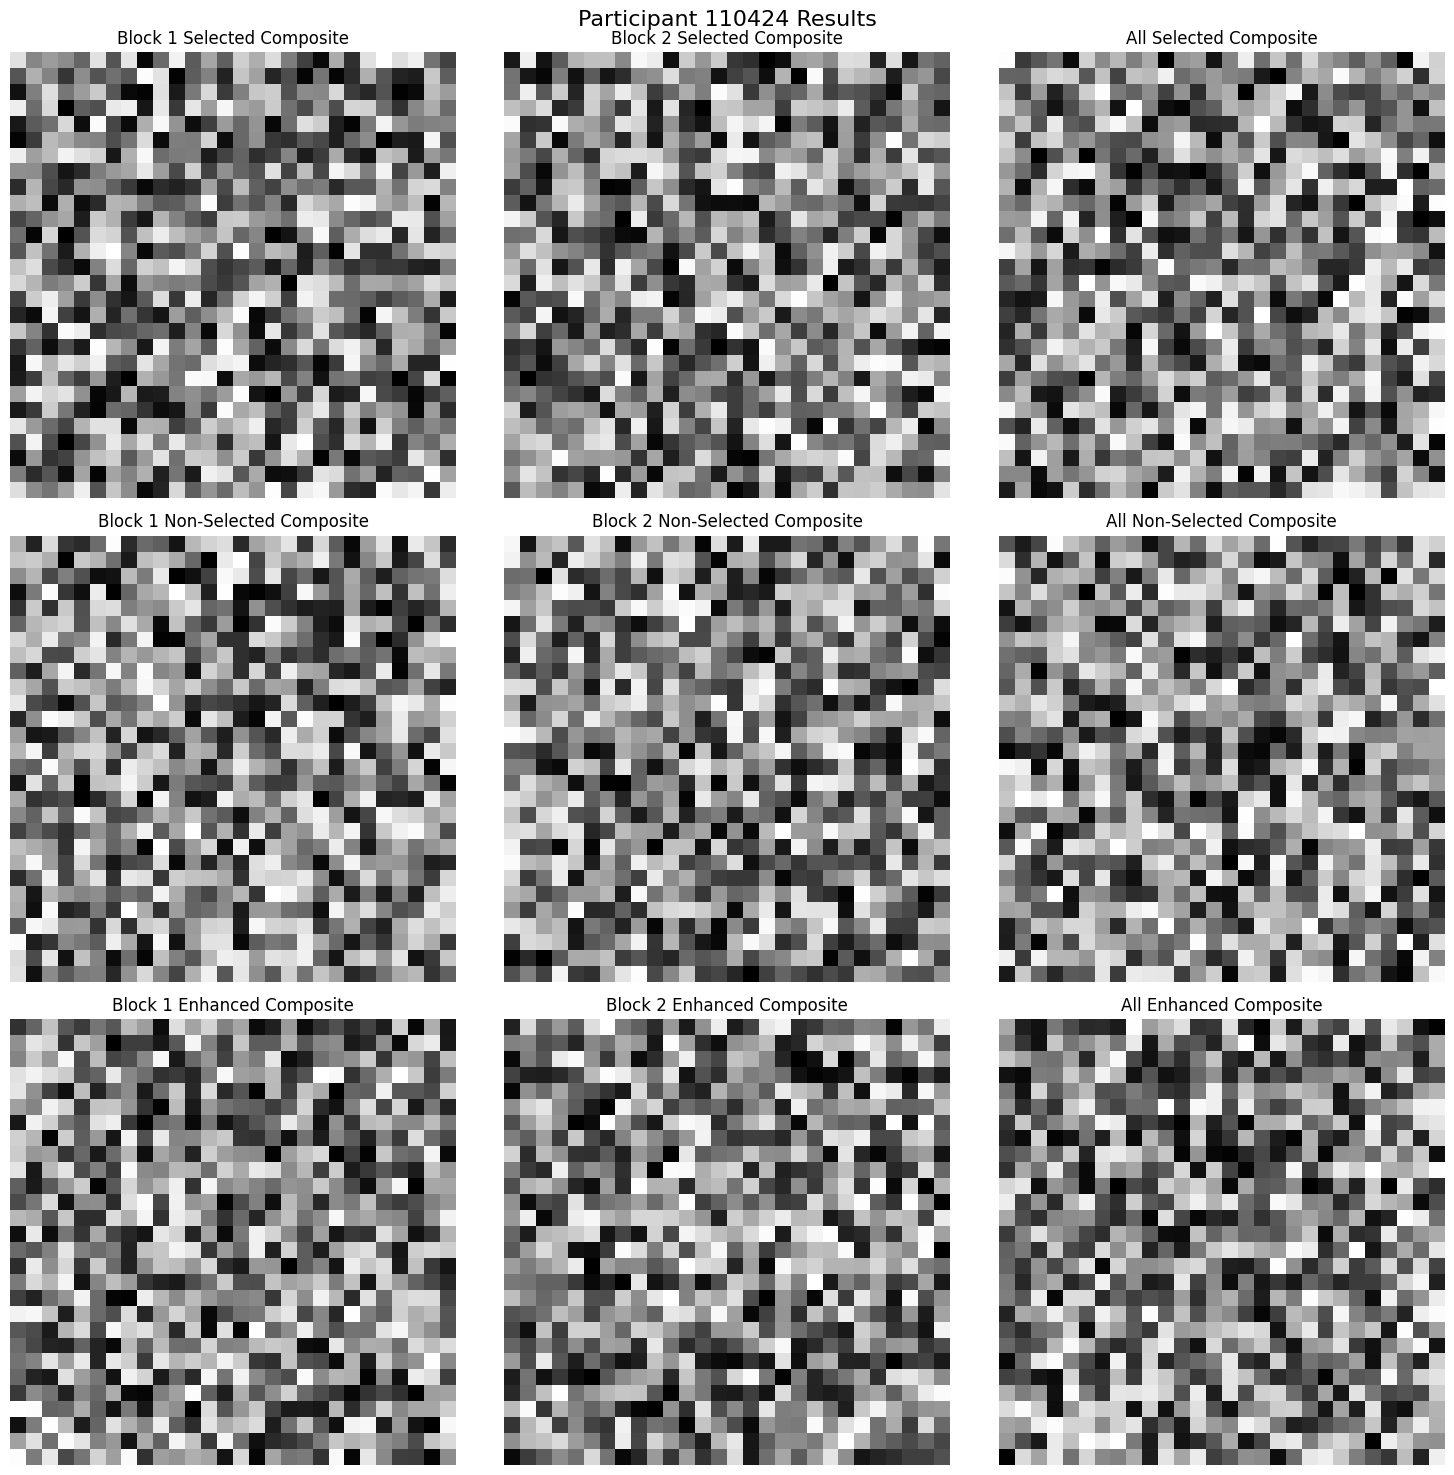

In [4]:
# Main execution
jrzip_file_path = 'jatos_results_20241104145840.jrzip'
all_participants_data = load_and_process_jrzip(jrzip_file_path)
display_results(all_participants_data)  # Use display_results instead of display_composites